In [2]:
import pandas as pd
import hdbscan
import re
from langchain_community.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict
import numpy as np
import json
import logging
from typing import Dict, List, Tuple
from IPython.display import Image, display

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch

# LLM: adapt to your environment (you already used ChatOllama)
from langchain_ollama import ChatOllama
from langchain.prompts import ChatPromptTemplate

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)
logging.getLogger("httpx").setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [3]:
df = pd.read_csv("data\online_retail.csv") 
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
df_by_stockcode = df.groupby('StockCode').agg({'Description': 'first'}).reset_index()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str).str.lower().str.strip()

df[df['Description'] == 'nan'].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,nan,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,nan,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,nan,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,nan,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,nan,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
1988,536550,85044,nan,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2024,536552,20950,nan,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom
2025,536553,37461,nan,3,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2026,536554,84670,nan,23,2010-12-01 14:35:00,0.0,NaN,United Kingdom
2406,536589,21777,nan,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom


In [7]:
# Data without duplicates, gift cards and manual entries
df_cleaned = df[(df['Description'] != 'manual') & (~df['StockCode'].str.startswith('gift')) & (df['Description'] != None) & (df['Description'] != 'samples') & (df['Description'] != 'nan') & (df['Description'].str.contains('postage') == False) & (df['Description'] != 'ebay') & (df['Description'].str.contains('wrongly') == False) & (df['Description'].str.contains('wet') == False) & (df['Description'].str.contains('dotcom') == False) & (df['Description'].str.contains('adjustment') == False)& (df['Description'].str.contains('damages') == False)& (df['Description'].str.contains('adjust') == False)]
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:

pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # (optional) show all columns

prod_df = df_cleaned.groupby('StockCode').agg({'Description': 'first', 'Quantity': 'sum', 'UnitPrice': 'sum'}).reset_index().sort_values(by='StockCode', ascending=True)
prod_df = prod_df.drop_duplicates()
prod_df = prod_df[prod_df['Quantity'] > 0]
prod_df = prod_df.reset_index(drop=True)
prod_df.shape
prod_df.head()


,StockCode,Description,Quantity,UnitPrice
0,10002,inflatable political globe,860,77.15
1,10080,groovy cactus inflatable,325,9.04
2,10120,doggy rubber,192,6.09
3,10123C,hearts wrapping tape,5,1.95
4,10124A,spots on red bookcover tape,16,2.10


In [9]:
df = prod_df.copy()

# 1️⃣ Normalize stock code (remove letters)
df['StockCode'] = df['StockCode'].astype(str).str.extract(r'(\d+)', expand=False)

# 2️⃣ Normalize description (lowercase, remove punctuation)
df['Description'] = df['Description'].str.lower().str.replace(r'[^\w\s]', '', regex=True)


df = df.groupby('StockCode').agg({ 'Description': 'first'}).reset_index()

print(df.shape)

# ------------ Normalization ------------

MULTI_SPACE = re.compile(r'\s+')
BRAND_NOISE = re.compile(r'\b(asst|brand|new|sale|discount|offer|woodland|retrospot|retro spot|alpine)\b', re.IGNORECASE)
COLOR_NOISE = re.compile(r'\b(ruby|shell glass|monochrome|whitepink|chocblue|blacksilver|coloured|pearl|psychedelic|pinkpurple|pinkamethystgold|crystalglass|velvet|orangewhtfuschia|pinkwhite|pinkblue|pinkyellow|transparent|polkadots|lilac|redcream|lavender|skyblue|jade|blond|blackblue|whitepink|rose|fuschia|gingham|paisley|multicolour|clear|turquoise|yellowblue|yelloworange|yellowpink|bluecream|mint|ivory|pastel|red|blue|green|black|white|yellow|pink|purple|orange|grey|gray|brown|silver|gold|amber|golden|amethyst|polkadot|cream)\b', re.IGNORECASE)
CHARACTERISTIC_NOISE = re.compile(r'\b(artificial|rotating|fresh|glowing|glaze|long|soft|oval|mirror mosaic|diamond cluster|embossed|embroidery|chic|cake spotted|fluted|folding|stripey|stripes|glamorous|ridged|sphere|hexagon|cubic|square|squared|economy|rustic|house shape|circular|diamante shaped|honeycomb|floral|shaggy|mirrored|embroidered|metalic|brocante|beaded|round|faux|fancy|chick|cute|modern|victorian|rococo|vip|traditional|old|romantic|deluxe|polka dot|vanilla|polished|cosy|enamel|apothecary|camouflage|fluffy|childrens|bohemian|funky|chunky|circles|circle|chrysanthemum|classical|beads|butterflies|butterfly|bell|heart|ass|asstd|assorted|antique|vintage|classic|retro|baroque|acrylic|geometric|pretty|bead|abstract|aged|apple|charlotte|cherry blossom|zinc|bertie|buffalo bill|all)\b', re.IGNORECASE)
SIZE_NOISE = re.compile(r'\b(compact|combo|mini|fine|little|giant|jumbo|grand|small|medium|large|xl|xxl|xxxl|size|big|pack of [0-9]+|set of [0-9]+|of [0-9]+|set [0-9]+|set[0-9]+|pack [0-9]+|box[0-9]+|box [0-9]+|s[0-9]+|\d+\s?(?:x|×)\s?\d+\s?(?:cm|mm|m|in|inch|"))\b', re.IGNORECASE)
MATERIALS_NOISE = re.compile(r'\b(goldie|glasszinc|lattice|kashmir|quartz|zincglass|silverfat|silvernatural|silvercrystal|feather|diamante|crystal|silvermop|kashmiri|homemade|crochet|bamboo|wooden|plastic|ceramic|fabric|cotton|leather|silk|wool|linen|steel|iron|aluminium|aluminum|porcelain|resin|stone|marble|botanical)\b', re.IGNORECASE)
CONJUNCTIONS = re.compile(r'\b(for|y|and|with|&|plus|w|of|in)\b', re.IGNORECASE)
CITY_NAMES = re.compile(r'\b(chinese|columbian|st tropez|tokyo|london|paris|england|camden town|notting hill|bridge)\b', re.IGNORECASE)
RANDOM_WORDS = re.compile(r'\b(sticky|local|lucky|font|madras|collage|pick up|setting|settings|season|sandalwood|men|cheerful|foxy|cluster|jet|blkwhit|weekend|spotty|polka|icon|mr|mrs|namaste|silt squ|rosie|lace|relax|four|lovebirds|laundry|15c|multi|donkey|multicol|letter|flower|set|queens|guard|wise|curio|trim rainy|posies|haynes|hippy|holiday|cottage|friendship|come|flag|flock|tomato|sanskrit|gin tonic|diet|la palmiera|cannabis|leaf|ice|sundae|hydrangea|daisies|travelog|days|bili nut|beauty|flowr shell|birdy|flowers|poppies|space|dinosaurs|goldfish|check|crossbones|crusoe|basil|wildflower|cacti|folk|bitty|rim|capiz|perfect nativity|perfect tree|poinsettia|cinammon|citrus|hare|doiley|ping|boots|bonbon|yuletide|charlielola|chateau|chenille|mao|frog|marshmallow|leap|village|wire|pig|farmyard|feathers|fawn|50s|milkmaid|natural|rasta|pegs|ladies|rainbow|folkarts|folkart|football|flu|man|candy|ladybird|corona mexican|hottie|robin|fun|petals|fairy|apples|baroquecandlestick|cinnamon|allium|pantry|chicken|ingrid|helga|origami|lovehate|lovely|teatime|tea time|pirate|soldiers|peace|butterfl|animal|skulls|skull|rosebuds|pears|col|bunnies|bull dog|jazz|spaceman|rebecca|jack|jack flag|boxed|delight|hyacinth|hoop|horse|pony|child|childs|mothers|dads|cinderella|citronella|enamelglass|bakelike|sack|chocolate cupcakes|choc|egg milk choc|egg choc|way out|welcome|soldier|bird|birdhouse|afghan|the|leaves|lily|lovebird|pistachio|potting shed|scandinavian|summer|swallow|union|watermelon|freestyle|hanging|hanging metal|fruit salad|dove|edwardian|elephant|carnival|owls|groovy|girls|girly|gin tomic|diet|czech|home home|doily|empire|magic forest|dolly|carousel|cowboy|bauble|murano|lola|lolita|monster|magic garden|tranquility|tradtional|cherry|bubblegum|bubble gum|doughnut|regency|maye your own|marie antoienett|frangipani|keep calm|mums|mailout|sally|rachel|sohpie|enchanted|hello sailor|happy|midnight|queen skies|queen the skies|boudoir|noting hill|poppys|popart|pop art|peg|beadshand|bear|park|owl|raspberr|animals|alphabet|angel|airline|tutti frutti|tuscan villa|moroccan|grow your own|hearts|wicker|mum|mummy|des|dream|drop|babushka|monkey|french|cupid|crazy|cm|boy|boys|blossom|belle|tropical|suki|creatures|girl|babushka|spaceboy|skull|s|robot|riviera|dinosaur|spot|union jack|raspberry|heart shape|sweet|sweetheart|looking|painted|hour|finish|first class|d|parisienne|charlie|montana|heidi|maria|stripe|strawberry|spanish|english|german|danish|daisy|g|cm|beach|mom|mum|best|dad|bendy|copper|ant|boudicca|cracked|caravan|cracked glaze|feltcraft|felt|fern|kitty|hot|cherub|a|i|love|design|d|color|colourful|colour|style|cannabies|billboard|bfly|thank you|s)\b', re.IGNORECASE)
PHRASES_NOISE = re.compile(r'\b(perfect tree|out order|lads only|king choice|garden path|hi tec|one person|love secrets|am so poorly|sex bomb|to our home|guns roses|area patrolled|revolutionary|sleeping cats|lets go shopping|scottie dog|indians|if you cant stand heat|country|cote dazure|ooh la la|dark house|ruby glass|dairy maid|du sud|booze women|cowboys|willie winkie|nicole|tea party|take it or leave it|henrietta hen|birds|birdcage|gardenia morris|gardenia [0-9] wick morris|marie antoinette|cowboys indians|eau de nile|make your own|circus parade|abc treasure|youre confusing me|ruby glass cluster|wake up cockerel|star|snow|save planet|chocolate|chocolate this way|neighbourhood witch|her dinner is served|his dinner is served|paint your own|can only please one person|wise man|world champion)')

def normalize_description(desc: str) -> str:
    if not isinstance(desc, str):
        return ''
    s = desc.strip().lower()
    s = BRAND_NOISE.sub(' ', s)                  # drop promotional noise words
    s = COLOR_NOISE.sub(' ', s)                    # drop color noise words
    s = CHARACTERISTIC_NOISE.sub(' ', s)      # drop characteristic noise words
    s = SIZE_NOISE.sub(' ', s)                      # drop size noise words
    s = MATERIALS_NOISE.sub(' ', s)            # drop material noise words
    s = CITY_NAMES.sub(' ', s)                    # drop city names
    s = RANDOM_WORDS.sub(' ', s)                # drop random noise words                  
    s = CONJUNCTIONS.sub(' ', s)                  # drop conjunctions
    s = s.strip()
    s = PHRASES_NOISE.sub(' ', s)                # drop phrases
    s = MULTI_SPACE.sub(' ', s)
    s = s.strip()
    s = re.sub(r'^[0-9]+\s*', '', s)          # drop leading stock codes
    s = re.sub(r'\s*[0-9]+$', '', s)          # drop trailing stock codes
    s = RANDOM_WORDS.sub(' ', s)                # drop random noise words again
    s = MULTI_SPACE.sub(' ', s)
   
    
    return s.strip()

df['Description_norm'] = df['Description'].apply(normalize_description)
df['Description_norm'] = df['Description_norm'].replace('', None)

# Drop rows with null values 

df = df.dropna()
df = df.groupby('Description_norm').agg({'StockCode': 'first', 'Description': 'first'}).reset_index()


print(df.shape)

df.head(10)



(3246, 2)
(1919, 3)


,Description_norm,StockCode,Description
0,2 drawer cabinet,23405,home sweet home 2 drawer cabinet
1,a4 wall tidy office,71496,a4 wall tidy blue office
2,address book,20996,jazz hearts address book
3,advent calendar,22580,advent calendar gingham sack
4,alarm clock,22725,alarm clock bakelike chocolate
5,anemone,84802,white anemone artificial flower
6,angels tlight hldr,84347,rotating silver angels tlight hldr
7,aperitif glass,20826,silver aperitif glass
8,apron,21042,red retrospot apron
9,art,84800,large whitepink rose art flower


In [ ]:
# Smart clustering pipeline with optional HNSW (ChromaDB / hnswlib / sklearn fallback)



# ------------ Embedding helper ------------
class SmartProductClusterer:
    def __init__(self, model_name="all-MiniLM-L6-v2", device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        log.info(f"Loading embedding model {model_name} on {self.device}")
        self.model = SentenceTransformer(model_name, device=self.device)
        self.embeddings_cache: Dict[str, np.ndarray] = {}

    def get_embeddings(self, descriptions: List[str], batch_size: int = 32) -> np.ndarray:
        # Return embeddings in same order as descriptions
        result = []
        to_compute = []
        compute_idx = []
        for i, d in enumerate(descriptions):
            if d in self.embeddings_cache:
                result.append(self.embeddings_cache[d])
            else:
                result.append(None)
                to_compute.append(d)
                compute_idx.append(i)

        if to_compute:
            new_embs = self.model.encode(
                to_compute,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_numpy=True,
                normalize_embeddings=True
            )
            for idx, emb in zip(compute_idx, new_embs):
                result[idx] = emb
                self.embeddings_cache[descriptions[idx]] = emb

        return np.vstack(result)

# ------------ Robust JSON extraction for LLM outputs ------------
def _strip_code_fences(text: str) -> str:
    text = re.sub(r"```(?:json)?\s*([\s\S]*?)\s*```", r"\1", text, flags=re.IGNORECASE)
    text = re.sub(r"`([^`]+)`", r"\1", text)
    return text

def extract_json(text: str, max_chars: int = 20000) -> str:
    if not isinstance(text, str):
        raise ValueError("LLM output not a string")
    txt = _strip_code_fences(text[:max_chars]).strip()
    first_brace = txt.find('{')
    if first_brace == -1:
        raise ValueError("No JSON object start found")
    # try progressive parse from first brace
    closing_positions = [m.start() for m in re.finditer(r'\}', txt[first_brace:])]
    for rel in closing_positions:
        candidate = txt[first_brace:first_brace + rel + 1]
        if candidate.count('{') != candidate.count('}'):
            continue
        try:
            json.loads(candidate)
            return candidate
        except Exception:
            # attempt small cleanup of trailing commas
            cand = re.sub(r",\s*}", "}", candidate)
            cand = re.sub(r",\s*]", "]", cand)
            try:
                json.loads(cand)
                return cand
            except Exception:
                continue
    raise ValueError("Failed to extract valid JSON from LLM output. Sample:\n" + txt[:1000])

# ------------ LLM naming (single call) ------------
def llm_name_clusters(cluster_samples: Dict[int, List[str]], llm) -> Dict[int, Dict[str,str]]:
    # Build a short summary per cluster
    cluster_text_lines = []
    for cid, samples in cluster_samples.items():
        if cid == -1:
            continue
        examples = "\n".join(f"- {s}" for s in samples[:50])
        cluster_text_lines.append(f"Cluster {cid}:\n{examples}")
    cluster_text = "\n\n".join(cluster_text_lines) if cluster_text_lines else "No clusters."

    category_knowledge = """
| Category                    | Definition                                                              | Example Products                                                    |
| --------------------------- | ----------------------------------------------------------------------- | ------------------------------------------------------------------- |
| Home & Kitchen              | Items used for household purposes, cooking, or decor.                   | Cookware sets, cutlery, coffee makers, bedding, wall art            |
| Party Supplies              | Items used for celebrations and events.                                 | Balloons, banners, party hats, tableware, decorations              |
| Festive Supplies            | Items specifically for holiday or seasonal celebrations.                | Christmas decorations, Halloween costumes, Easter eggs             |
| Clothing & Apparel          | Wearable items for men, women, and children.                            | T-shirts, jeans, dresses, jackets, socks, hats                      |
| Toys & Games                | Items for play, recreation, or educational purposes.                    | Board games, action figures, dolls, puzzles, LEGO sets              |
| Books, Music & Media        | Physical or digital media for learning or entertainment.                | Novels, textbooks, vinyl records, eBooks, DVDs                      |
| Pet Supplies                | Items for pet care, food, and accessories.                              | Dog food, cat litter, pet beds, leashes, collars                    |
| Jewelry & Accessories       | Decorative items worn on the body or used to enhance outfits.           | Necklaces, rings, watches, handbags, belts                          |
| Office Supplies             | Products for professional or educational workspaces.                    | Pens, notebooks, printers, staplers, organizers                     |
| Garden & Outdoor            | Items for gardening, outdoor living, or landscaping.                    | Planters, lawn mowers, patio furniture, outdoor lights              |
"""

    prompt = ChatPromptTemplate.from_messages([
        ("system",
        f"You are an expert at naming product categories for e-commerce. "
        "Use the following reference table when naming clusters:\n{category_knowledge}\n\n"
        "Return a single JSON object (no extra text) mapping cluster IDs (strings) to objects "
        "with keys 'category_name' and 'reason'. Keep category_name short (2-4 words)."),
        ("user",
        "Here are clusters with examples:\n\n{cluster_text}\n\n"
        "Return JSON like: "
        '{{"0": {{"category_name": "Kitchen Gadgets", "reason": "small handy kitchen tools."}}, "...": {{...}}}}')
    ])


    formatted = prompt.format_messages(cluster_text=cluster_text, category_knowledge=category_knowledge)
    response = llm.invoke(formatted)
    raw = response.content
    log.info("Raw LLM cluster-naming response (truncated):\n%s", raw[:1000])

    try:
        cleaned = extract_json(raw)
        parsed = json.loads(cleaned)
        out = {}
        for k, v in parsed.items():
            try:
                cid = int(k)
            except Exception:
                # try to extract digits
                digits = re.sub(r"[^\d-]+", "", str(k))
                cid = int(digits) if digits else k
            out[int(cid)] = {
                "category_name": v.get("category_name", f"Cluster_{cid}"),
                "reason": v.get("reason", "No reason provided")
            }
        return out
    except Exception as ex:
        log.warning("LLM cluster naming parse failed: %s", ex)
        # fallback trivial naming
        fallback = {int(cid): {"category_name": f"Cluster_{cid}", "reason": "Fallback naming"} 
                    for cid in cluster_samples.keys() if cid != -1}
        return fallback

def build_taxonomy(df: pd.DataFrame, clusterer: SmartProductClusterer,
                   min_cluster_size) -> Tuple[Dict[int,List[str]], Dict[str,int], np.ndarray, List[str]]:
    """
    Simplified taxonomy builder: embeddings + HDBSCAN (no HNSW).
    """
    unique_descs = df['Description_norm'].unique().tolist()
    log.info("Unique descriptions: %d", len(unique_descs))

    embeddings = clusterer.get_embeddings(unique_descs)

    # Cluster directly on embeddings
    cluster_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, max_cluster_size=500, min_samples=1, metric='euclidean')
    clusters = cluster_model.fit_predict(embeddings)

    desc_to_cluster = {d: int(c) for d, c in zip(unique_descs, clusters)}
    df['Cluster'] = df['Description_norm'].map(desc_to_cluster)

    cluster_samples: Dict[int, List[str]] = {}
    for cid in sorted(set(clusters)):
        if cid == -1:
            continue
        examples = df[df['Cluster'] == cid]['Description'].drop_duplicates().tolist()
        cluster_samples[int(cid)] = examples
        log.info("Cluster %s: %d examples", cid, len(examples))

    return cluster_samples, desc_to_cluster, embeddings, unique_descs


def assign_smart_categories(df: pd.DataFrame, taxonomy: Dict[int, Dict[str,str]], desc_to_cluster: Dict[str,int]) -> pd.DataFrame:
    records = []
    for idx, row in df.iterrows():
        cid = desc_to_cluster.get(row['Description_norm'], -1)
        out = row.to_dict()
        if cid == -1:
            out['Category'] = 'Uncategorized'
            out['Confidence'] = 0.0
            out['Reason'] = 'no_cluster'
        else:
            cluster_info = taxonomy.get(cid, {})
            out['Category'] = cluster_info.get('category_name', f'Cluster_{cid}')
            out['Confidence'] = 0.8
            out['Reason'] = 'embedding_cluster'
        records.append(out)
    return pd.DataFrame.from_records(records)

def smart_similarity_reassignment(categorized_df: pd.DataFrame, embeddings: np.ndarray, unique_descs: List[str],
                                  desc_to_cluster: Dict[str,int], taxonomy: Dict[int, Dict[str,str]], threshold: float) -> pd.DataFrame:
    desc_to_emb = {d: emb for d, emb in zip(unique_descs, embeddings)}
    cluster_centroids = {}
    for cid in taxonomy.keys():
        cluster_descs = [desc for desc, c in desc_to_cluster.items() if c == cid]
        if cluster_descs:
            cluster_embeddings = np.array([desc_to_emb[desc] for desc in cluster_descs])
            cluster_centroids[cid] = cluster_embeddings.mean(axis=0)
    reassigned = 0
    mask = categorized_df['Category'] == 'Uncategorized'
    for idx in categorized_df[mask].index:
        dnorm = categorized_df.at[idx, 'Description_norm']
        emb = desc_to_emb.get(dnorm)
        if emb is None:
            continue
        sims = {cid: float(cosine_similarity([emb], [centroid])[0,0]) for cid, centroid in cluster_centroids.items()}
        if not sims:
            continue
        best_cid, best_sim = max(sims.items(), key=lambda x: x[1])
        if best_sim >= threshold:
            categorized_df.at[idx, 'Category'] = taxonomy[best_cid]['category_name']
            categorized_df.at[idx, 'Confidence'] = float(best_sim)
            categorized_df.at[idx, 'Reason'] = 'similarity_reassigned'
            reassigned += 1
    log.info("Reassigned %d items via similarity", reassigned)
    return categorized_df

# ------------ High-level pipeline wrapper ------------
def smart_cluster_products(df: pd.DataFrame,
                           model_name: str = "all-MiniLM-L6-v2",
                           min_cluster_size: int = 5,
                           similarity_threshold: float = 0.4,
                           output_file: str = "smart_categorized.parquet") -> Tuple[pd.DataFrame, Dict[int, Dict[str,str]]]:
    
    llm = ChatOllama(model="llama3.2:1b", temperature=0.5, top_k=50, top_p=0.8)
    clusterer = SmartProductClusterer(model_name=model_name)

    # normalization
    df = df.copy()
    

    # build taxonomy with HNSW neighbor graph + HDBSCAN on embeddings
    cluster_samples, desc_to_cluster, embeddings, unique_descs = build_taxonomy(
    df, clusterer, min_cluster_size=min_cluster_size)


    # name clusters via single LLM call
    taxonomy = llm_name_clusters(cluster_samples, llm)

    # assign categories
    categorized = assign_smart_categories(df, taxonomy, desc_to_cluster)

    # similarity reassignment for Uncategorized
    final_df = smart_similarity_reassignment(categorized, embeddings, unique_descs, desc_to_cluster,
                                             taxonomy, threshold=similarity_threshold)

    # save
    final_df.to_parquet(output_file, index=False)
    log.info("Saved results to %s", output_file)
    return final_df, taxonomy

df = df.copy()
final_df, taxonomy = smart_cluster_products(df, model_name="all-MiniLM-L6-v2", min_cluster_size=20, similarity_threshold=0.6)
print(final_df.head())
print("Taxonomy:", taxonomy)



INFO:__main__:Loading embedding model all-MiniLM-L6-v2 on cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:__main__:Unique descriptions: 1919


Batches:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:__main__:Cluster 0: 31 examples
INFO:__main__:Cluster 1: 26 examples
INFO:__main__:Cluster 2: 27 examples
INFO:__main__:Cluster 3: 32 examples
INFO:__main__:Cluster 4: 28 examples
INFO:__main__:Cluster 5: 25 examples
INFO:__main__:Cluster 6: 91 examples
INFO:__main__:Cluster 7: 62 examples
INFO:__main__:Cluster 8: 148 examples
INFO:__main__:Cluster 9: 43 examples
INFO:__main__:Cluster 10: 59 examples


In [ ]:
final_df['Category'].value_counts()

Uncategorized              1224
Multicolour Decorations     182
Garden & Outdoor            106
Home Decor                   77
Assorted Crafts              66
Folk Art                     63
Festive Supplies             43
Jewelry & Accessories        35
Clothing & Apparel           33
Kitchen Gadgets              33
Party Supplies               31
Office Supplies              26
Name: Category, dtype: int64

In [ ]:
final_df.head(10)

,Description_norm,StockCode,Description,Cluster,Category,Confidence,Reason
0,2 drawer cabinet,23405,home sweet home 2 drawer cabinet,6,Garden & Outdoor,0.8,embedding_cluster
1,a4 wall tidy office,71496,a4 wall tidy blue office,-1,Uncategorized,0.0,no_cluster
2,address book,20996,jazz hearts address book,-1,Uncategorized,0.0,no_cluster
3,advent calendar,22580,advent calendar gingham sack,-1,Uncategorized,0.0,no_cluster
4,alarm clock,22725,alarm clock bakelike chocolate,3,Clothing & Apparel,0.8,embedding_cluster
5,anemone,84802,white anemone artificial flower,-1,Uncategorized,0.0,no_cluster
6,angels tlight hldr,84347,rotating silver angels tlight hldr,-1,Uncategorized,0.0,no_cluster
7,aperitif glass,20826,silver aperitif glass,-1,Uncategorized,0.0,no_cluster
8,apron,21042,red retrospot apron,-1,Uncategorized,0.0,no_cluster
9,art,84800,large whitepink rose art flower,-1,Uncategorized,0.0,no_cluster


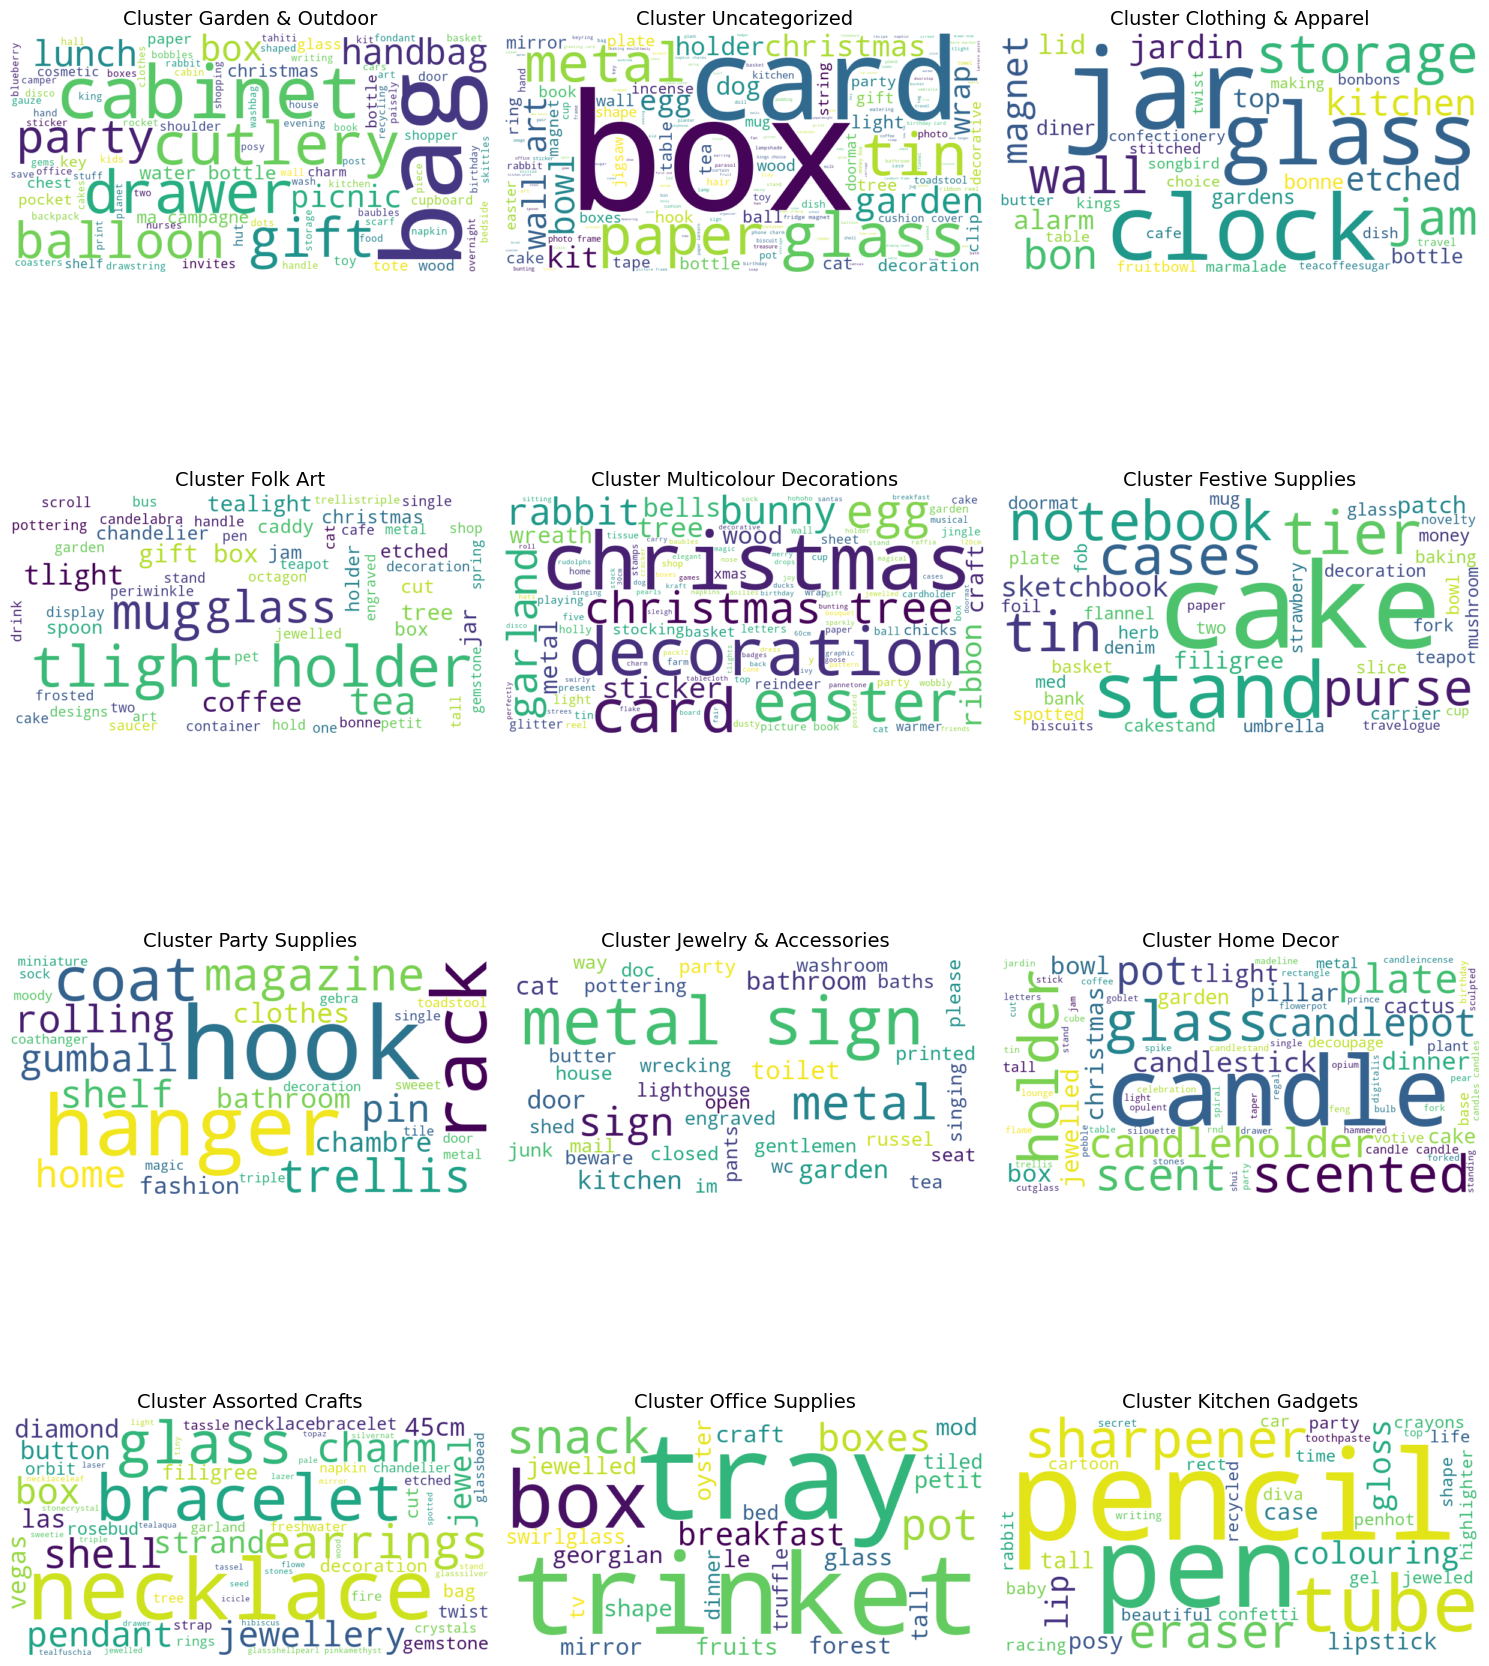

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds_by_cluster(df, max_clusters=12):
    """
    Plot word clouds for clusters using Description_norm.
    Each cluster gets its own subplot.
    
    df: DataFrame with columns ['Cluster', 'Description_norm']
    max_clusters: maximum number of clusters to plot (for readability)
    """
    clusters = df['Category'].unique()
    clusters = [c for c in clusters if c != -1]  # drop noise if any
    clusters = clusters[:max_clusters]

    n_clusters = len(clusters)
    ncols = 3
    nrows = (n_clusters + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, cid in enumerate(clusters):
        text = " ".join(df.loc[df['Category'] == cid, 'Description_norm'])
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"Cluster {cid}", fontsize=14)
        axes[i].axis("off")

    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()

    plt.savefig("wordclouds_by_cluster.png")
    plt.show()
plot_wordclouds_by_cluster(final_df, max_clusters=12)

In [ ]:

# -------- Agent fallback --------
# Initialize LLM (you might want to use a better model)
llm = ChatOllama(
        model="llama3.2:1b",
        temperature=0.9,  
        top_k=50,
        top_p=0.8,
    )

# ---------- LangGraph State ----------
class ProductState(TypedDict):
    product: str
    taxonomy: Dict[int, Dict[str, str]]
    counterproposal: str
    accepted: bool
    retries: int
    proposal: str
    reason: str
    

# ---------- Agents ----------
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser


# ---------- Pydantic Schemas with Fields ----------

class GeneratorOutput(BaseModel):
    proposal: str = Field(
        description="The proposed category for the product (string or 'Uncategorized')"
    )
    reason: str = Field(
        description="A short justification for why this category was chosen"
    )


class EvaluatorOutput(BaseModel):
    accepted: bool = Field(
        description="Whether the evaluator accepts the proposed category (True/False)"
    )
    counterproposal: str = Field(
        description="If not accepted, a counterproposal for the category (string or 'Uncategorized')"
    )


class MediatorOutput(BaseModel):
    final_category: str = Field(
        description="The FINAL category chosen for the product (string or 'Uncategorized')"
    )
    reason: str = Field(
        description="A short justification for the final categorization decision"
    )



def extract_json(text: str) -> str:
    """Extract the first valid JSON object from text."""
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        raise ValueError(f"No JSON found in response: {text}")
    return match.group(0)


category_knowledge = """
| Category                    | Definition                                                              | Example Products                                                    |
| --------------------------- | ----------------------------------------------------------------------- | ------------------------------------------------------------------- |
| Home & Kitchen              | Items used for household purposes, cooking, or decor.                   | Cookware sets, cutlery, coffee makers, bedding, wall art            |
| Party Supplies               | Items used for celebrations and events.                                 | Balloons, banners, party hats, tableware, decorations              |
| Festive Supplies            | Items specifically for holiday or seasonal celebrations.                | Christmas decorations, Halloween costumes, Easter eggs             |
| Clothing & Apparel          | Wearable items for men, women, and children.                            | T-shirts, jeans, dresses, jackets, socks, hats                      |
| Toys & Games                | Items for play, recreation, or educational purposes.                    | Board games, action figures, dolls, puzzles, LEGO sets              |
| Books, Music & Media        | Physical or digital media for learning or entertainment.                | Novels, textbooks, vinyl records, eBooks, DVDs                      |
| Pet Supplies                | Items for pet care, food, and accessories.                              | Dog food, cat litter, pet beds, leashes, collars                    |
| Jewelry & Accessories       | Decorative items worn on the body or used to enhance outfits.           | Necklaces, rings, watches, handbags, belts                          |
| Office Supplies             | Products for professional or educational workspaces.                    | Pens, notebooks, printers, staplers, organizers                     |
| Garden & Outdoor            | Items for gardening, outdoor living, or landscaping.                    | Planters, lawn mowers, patio furniture, outdoor lights              |
"""

# ---------- Agents with schema enforcement (Pydantic v2) ----------
def generator_agent(state: ProductState) -> ProductState:
    product = state["product"]
    taxonomy = state["taxonomy"]
    counterproposal = state["counterproposal"]

    taxonomy_text = "\n".join(
        f"- {cid}: {info['category_name']} ({info['reason']})"
        for cid, info in taxonomy.items()
    )

    print(f"\n🟢 Generator Agent running for product: {product}")

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a knowledgeable assistant that classifies products into categories and proposes category names. "
    "Use the following reference table when naming categories:{category_knowledge}"
     "Respond ONLY in strict JSON. Do not wrap JSON in strings. Do not escape quotes. The proposal must be a plain string, not JSON inside JSON."    
    "category name must be a string.Respond ONLY with valid JSON. "
    "IMPORTANT: Propose ONLY 1 category name per product. "
    "JSON format must be EXACT {{'proposal': '<category name or Uncategorized>', 'reason': '<short justification>'}}"),
        ("user", """Product: {product}
         Evaluator: {counterproposal}
Here is the taxonomy of categories:
{taxonomy}


Respond ONLY with valid JSON:
{{
  "proposal": "<category name or Uncategorized>",
  "reason": "<short justification>"

}}""")
    ])

    formatted = prompt.format_messages(
        product=product,
        taxonomy=taxonomy_text,
        counterproposal=counterproposal,
        category_knowledge=category_knowledge
    )
    

    
    response = llm.invoke(formatted)


   
    print(f"  Raw LLM response: {response.content}")

    try:
        parsed = PydanticOutputParser(pydantic_object=GeneratorOutput).parse(response.content.strip())
        #parsed = GeneratorOutput.model_validate_json(cleaned)
        output = {
            "proposal": str(parsed.proposal),
            "counterproposal": str(counterproposal),
            "reason": str(parsed.reason),
            "accepted": False,
            "taxonomy": taxonomy,
            "product": product,
            "retries": state.get("retries", 0)
        }
        return output


    except Exception as e:
        print(f"  ❌ Validation error in generator: {str(e)}")
        return {
            "proposal": "Uncategorized",
            "counterproposal": f"ParseError: {str(e)}",
            "reason": f"ParseError: {str(e)}",
            "accepted": False,
            "taxonomy": taxonomy,
            "product": product,
            "retries": state.get("retries", 0)
        }
    


def evaluator_agent(state: ProductState) -> ProductState:
    product = state["product"]
    proposal = state["proposal"]
    taxonomy = state["taxonomy"]
    reason = state["reason"]

    taxonomy_text = "\n".join(
        f"- {cid}: {info['category_name']} ({info['reason']})"
        for cid, info in taxonomy.items()
    )


    print(f"\n🔎 Evaluator Agent checking product: {product}, proposed category: {proposal}")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an experienced evaluator that accept or reject category name proposals."
         "Use the following reference table when naming categories:{category_knowledge}"
     "Respond ONLY in strict JSON. Do not wrap JSON in strings. Do not escape quotes. The counterproposal must be a plain string, not JSON inside JSON."
     "IMPORTANT: Propose ONLY 1 counterproposal per product. "
    "JSON format must be EXACT"),
        ("user", """Product: {product}
         Proposal: {proposal}
         Reason: {reason}
         counterproposal: your proposed category name, agreed or Uncategorized
        
        
Respond ONLY in JSON:
{{
  "accepted": "True/False",
  "counterproposal": "<category name, agreed or Uncategorized>"
}}""")
    ])

    
    formatted = prompt.format_messages(
            product=product,
            proposal=proposal,
            taxonomy=taxonomy_text,
            reason=reason,
            category_knowledge=category_knowledge
        )
    

    
    response = llm.invoke(formatted)


    print(f"  Raw Evaluator LLM response: {response.content}")

    try:
        parsed = PydanticOutputParser(pydantic_object=EvaluatorOutput).parse(response.content.strip())
        #parsed = EvaluatorOutput.model_validate_json(cleaned)
        if parsed.accepted == False:
                state["retries"] = state.get("retries", 0) + 1
        return {
            "proposal": proposal,
            "counterproposal": str(parsed.counterproposal),
            "reason": reason,
            "accepted": parsed.accepted,
            "product": product,
            "taxonomy": state["taxonomy"],
            "retries": state.get("retries", 0)
        }

        
    except Exception as e:
        print(f"  ❌ Validation error in evaluator: {str(e)}")
        return {
            "proposal": proposal,
            "counterproposal": f"ParseError: {str(e)}",
            "reason": f"ParseError: {str(e)}",
            "accepted": False,
            "product": product,
            "taxonomy": state["taxonomy"],
            "retries": state.get("retries", 0)
        }


def mediator_agent(state: ProductState) -> ProductState:
    product = state["product"]
    proposal = state["proposal"]
    counterproposal = state["counterproposal"]
   

    print(f"\n🤝 Mediator Agent resolving conflict for: {product}")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a mediator. Your job is to make a FINAL decision on product categorization."
          "Use the following reference table when naming categories:{category_knowledge}"
     "Respond ONLY in strict JSON. Do not wrap JSON in strings. Do not escape quotes. The proposal must be a plain string, not JSON inside JSON."),
        ("user", """Product: {product}
Last generator proposal: {proposal}
Evaluator feedback: {counterproposal}
         


Respond ONLY in JSON:
{{
  "final_category": "<chosen category or 'Uncategorized'>",
  "reason": "<short justification>"
}}""")
    ])

    
    formatted = prompt.format_messages(
        product=product,
        proposal=proposal,
        counterproposal=counterproposal,
        category_knowledge=category_knowledge
    )

    response = llm.invoke(formatted)
    
    print(f"  Raw Mediator LLM response: {response.content}")

    try:
        parsed = PydanticOutputParser(pydantic_object=MediatorOutput).parse(response.content.strip())
        #parsed = MediatorOutput.model_validate_json(cleaned)
        return {
            "proposal": parsed.final_category,
            "counterproposal": str(counterproposal),
            "reason": parsed.reason,
            "accepted": False,
            "taxonomy": state["taxonomy"],
            "product": product,
            "retries": state.get("retries", 0)
        }
    except Exception as e:
        print(f"  ❌ Mediator parsing error: {str(e)}")
        return {
            "proposal": "Uncategorized",
            "counterproposal": str(counterproposal),
            "reason": f"MediatorParseError: {str(e)}",
            "accepted": True,  # mark as final anyway
            "taxonomy": state["taxonomy"],
            "product": product,
            "retries": state.get("retries", 0)
        }
  


def router(state: ProductState) -> str:
    state["retries"] += 1
    # increment only here
   

    if state.get("accepted", False):
        return "accept"

    print(f"🔄 Retry count for product '{state['product']}': {state.get('retries', 0)}")

    if state["retries"] >= 1:  # after generator+evaluator run twice
        print(f"🛑 Escalating to mediator for product: {state['product']}")
        return "mediate"

    
    return "retry"




def finalizer(state: ProductState) -> ProductState:
    print(f"\n✅ Finalized classification for product: {state['product']} -> {state['proposal']}")
    return state

# ---------- LangGraph Builder ----------
builder = StateGraph(ProductState)
builder.add_node("generator", generator_agent)
builder.add_node("evaluator", evaluator_agent)
builder.add_node("mediator", mediator_agent)
builder.add_node("finalizer", finalizer)

builder.set_entry_point("generator")
builder.add_edge("generator", "evaluator")
builder.add_conditional_edges("evaluator", router, {
    "retry": "generator",   # one retry only
    "mediate": "mediator",  # mediator takes over after 2nd failure
    "accept": "finalizer"
})

builder.add_edge("mediator", "finalizer")
builder.add_edge("finalizer", END)

graph = builder.compile()




# ---------- Wrapper with chunked processing ----------
def agent_classify_uncategorized_chunked(df, taxonomy, chunk_size=30, max_loops=1):
    """
    Run LangGraph agent pipeline on Uncategorized rows in chunks.
    - chunk_size: number of products processed per batch
    - max_loops: max retries per chunk before finalizing
    """
    print("Starting agent classification for Uncategorized items in chunks...")

    taxonomy_str_keys = {str(k): v for k, v in taxonomy.items()}

    uncategorized_idx = df[df['Category'] == 'Uncategorized'].index.tolist()
    total = len(uncategorized_idx)
    print(f"  Total Uncategorized items: {total}")

    for loop in range(max_loops):
        print(f"\n🔄 Loop {loop + 1}/{max_loops}")
        if not uncategorized_idx:
            break

        # Process in chunks
        for start in range(0, len(uncategorized_idx), chunk_size):
            chunk_idx = uncategorized_idx[start:start + chunk_size]
            print(f"  Processing chunk {start // chunk_size + 1}: {len(chunk_idx)} items")

            for idx in chunk_idx:
                row = df.loc[idx]
                state = {
                    "product": row["Description_norm"],
                    "retries": 0,
                    "counterproposal": "Uncategorized",
                    "taxonomy": taxonomy_str_keys,
                    "proposal": "Uncategorized",
                    "reason": "Not yet classified",
                    "accepted": True
                }
                final_state = graph.invoke(state)
                display(Image(graph.get_graph().draw_mermaid_png()))
                df.at[idx, "Category"] = final_state["proposal"]
                df.at[idx, "Reason"] = final_state["reason"]
                df.at[idx, "Confidence"] = 0.7 if final_state["accepted"] else 0.5

        # Re-evaluate uncategorized list for next loop
        uncategorized_idx = df[df['Category'] == 'Uncategorized'].index.tolist()
        print(f"  Uncategorized remaining after loop {loop + 1}: {len(uncategorized_idx)}")

    return df

import random

def agent_classify_sample(df, taxonomy, sample_size=30):
    """
    Run LangGraph agent pipeline on a random sample of Uncategorized rows.
    - sample_size: number of products to sample
    - max_loops: max retries per product before finalizing
    """
    print(f"🎯 Running agent classification TEST on {sample_size} random Uncategorized items...")

    taxonomy_str_keys = {str(k): v for k, v in taxonomy.items()}

    # Select random sample of uncategorized rows
    uncategorized_idx = df[df['Category'] == 'Uncategorized'].index.tolist()
    if not uncategorized_idx:
        print("✅ No uncategorized items found!")
        return pd.DataFrame()

    sample_idx = random.sample(uncategorized_idx, min(sample_size, len(uncategorized_idx)))
    print(f"  Sample size: {len(sample_idx)}")

    results = []


    for idx in sample_idx:
            row = df.loc[idx]
            state = {
                "product": row["Description_norm"],
                "retries": 0,
                "counterproposal": "Uncategorized",
                "taxonomy": taxonomy_str_keys,
                "proposal": "Uncategorized",
                "reason": "Not yet classified",
                "accepted": True
            }
            final_state = graph.invoke(state)
            display(Image(graph.get_graph().draw_mermaid_png()))
            results.append({
                "Index": idx,
                "Product": row["Description_norm"],
                "Category": final_state["proposal"],
                "Reason": final_state["reason"],
                "Confidence": 0.7 if final_state["accepted"] else 0.5
            })

    sample_df = pd.DataFrame(results)
    print("\n✅ Test run complete. Returning sample results.")
    return sample_df



# ------------ Orchestration with chunked agent processing ------------
def run_pipeline_chunked(df: pd.DataFrame, taxonomy, chunk_size=50):
    print("\n🚀 Running full categorization pipeline with chunked agent classification...")

    
    # Step 4: LangGraph agent on chunks
    final_result = agent_classify_uncategorized_chunked(df, taxonomy, chunk_size=chunk_size, max_loops=3)
    print("\n✅ Pipeline complete.")
    return final_result


# ---------- Run ----------
test_result = agent_classify_sample(final_df, taxonomy, sample_size=20)


🎯 Running agent classification TEST on 30 random Uncategorized items...
  Sample size: 30

🟢 Generator Agent running for product: suede cushion cover
  Raw LLM response: {"proposal": "Clothing & Apparel", "reason": "wearable items for men, women, and children."}

🔎 Evaluator Agent checking product: suede cushion cover, proposed category: Clothing & Apparel
  Raw Evaluator LLM response: {
  "accepted": "True",
  "counterproposal": "Clothing & Apparel"
}

✅ Finalized classification for product: suede cushion cover -> Clothing & Apparel

🟢 Generator Agent running for product: oil burner
  Raw LLM response: {
  "proposal": "Oil Burner",
  "reason": "It is an essential item for kitchens."
}

🔎 Evaluator Agent checking product: oil burner, proposed category: Oil Burner
  Raw Evaluator LLM response: {
  "accepted": "True",
  "counterproposal": "Home & Kitchen"
}

✅ Finalized classification for product: oil burner -> Oil Burner

🟢 Generator Agent running for product: wood stamp wishes
  Raw LL

In [ ]:
test_result

,Index,Product,Category,Reason,Confidence
0,974,lantern,Lantern,Used for lighting purposes in various settings.,0.7
1,1032,magnets photo,Art Supplies,Magnetic Photo Frames can be used as a creativ...,0.5
2,680,gauze lampshade,Home & Kitchen,Lampshade is a decorative item used in a speci...,0.5
3,1884,windsock,Home & Kitchen,Windsocks are typically used indoors for decor...,0.5
4,1914,wrapping tape,Home & Kitchen,due to its common use for decorating and organ...,0.5


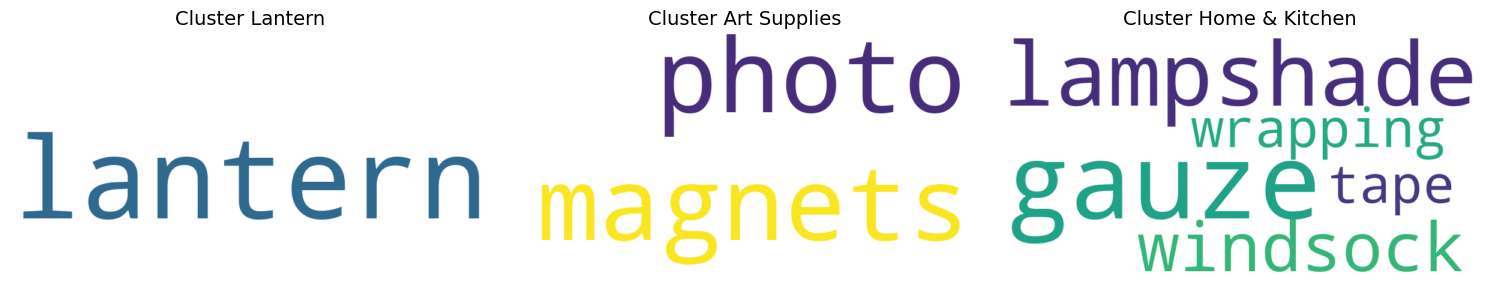

In [ ]:
def plot_wordclouds_by_category(df, max_clusters=12):
    """
    Plot word clouds for clusters using Description_norm.
    Each cluster gets its own subplot.
    
    df: DataFrame with columns ['Cluster', 'Product']
    max_clusters: maximum number of clusters to plot (for readability)
    """
    clusters = df['Category'].unique()
    clusters = [c for c in clusters if c != -1]  # drop noise if any
    clusters = clusters[:max_clusters]

    n_clusters = len(clusters)
    ncols = 3
    nrows = (n_clusters + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, cid in enumerate(clusters):
        text = " ".join(df.loc[df['Category'] == cid, 'Product'])
        wc = WordCloud(width=800, height=400, background_color="white").generate(text)
        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].set_title(f"Cluster {cid}", fontsize=14)
        axes[i].axis("off")

    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("wordclouds_by_agents.png")
    plt.show()
plot_wordclouds_by_category(test_result, max_clusters=12)
